In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install ktrain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.3/25.3 MB 30.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 70.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 653.6/653.6 kB 55.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 77.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 68.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.8/468.8 kB 38.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━

**XLM-Roberta**

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification, AdamW

# Load the CSV file
data = pd.read_csv("/content/drive/MyDrive/merge_check.csv")

# Remove rows with missing values
data = data.dropna(subset=["Headline", "Content", "Label"])

# Extract the text and label columns from the CSV
texts = data["Headline"] + " " + data["Content"]
labels = data["Label"].tolist()

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.3, random_state=42)

# Initialize the XLM-RoBERTa tokenizer
tokenizer = XLMRobertaTokenizer.from_pretrained("xlm-roberta-base")

# Tokenize the texts
X_train_tokens = tokenizer.batch_encode_plus(
    X_train.tolist(),
    padding=True,
    truncation=True,
    max_length=256,
    return_tensors="pt"
)
X_test_tokens = tokenizer.batch_encode_plus(
    X_test.tolist(),
    padding=True,
    truncation=True,
    max_length=256,
    return_tensors="pt"
)

# Create a custom dataset
class CustomDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: tensor[idx] for key, tensor in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Create dataloaders for training and testing
train_dataset = CustomDataset(X_train_tokens, y_train)
test_dataset = CustomDataset(X_test_tokens, y_test)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8)

# Initialize the XLM-RoBERTa model for sequence classification
model = XLMRobertaForSequenceClassification.from_pretrained("xlm-roberta-base", num_labels=2)

# Set the device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Training loop
model.train()
for epoch in range(10):
    train_loss = 0.0
    for batch in train_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        train_loss += loss.item()

        loss.backward()
        optimizer.step()

    train_loss /= len(train_loader)
    print(f"Epoch {epoch+1} - Training loss: {train_loss:.4f}")

# Evaluation
model.eval()
y_pred = []
y_true = []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        predictions = torch.argmax(logits, dim=1)

        y_pred.extend(predictions.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

# Calculate evaluation metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.dense.weight', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.d

Epoch 1 - Training loss: 0.3360
Epoch 2 - Training loss: 0.1910
Epoch 3 - Training loss: 0.1282
Epoch 4 - Training loss: 0.1074
Epoch 5 - Training loss: 0.0820
Epoch 6 - Training loss: 0.0584
Epoch 7 - Training loss: 0.0543
Epoch 8 - Training loss: 0.0395
Epoch 9 - Training loss: 0.0396
Epoch 10 - Training loss: 0.0306
Accuracy: 0.9005
Precision: 0.8259
Recall: 0.9867
F1 Score: 0.8992


Accuracy: 0.9005
Precision: 0.8259
Recall: 0.9867
F1-Score: 0.8992


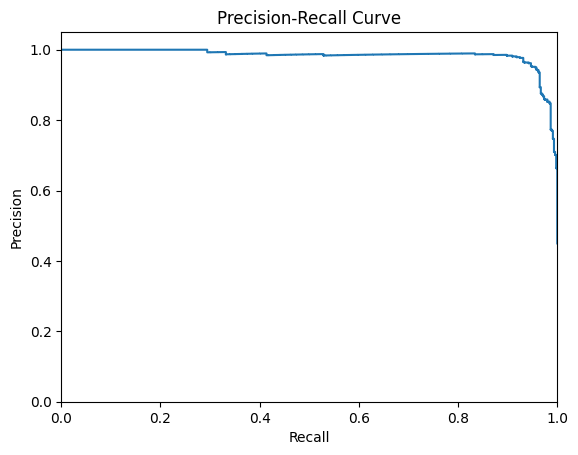

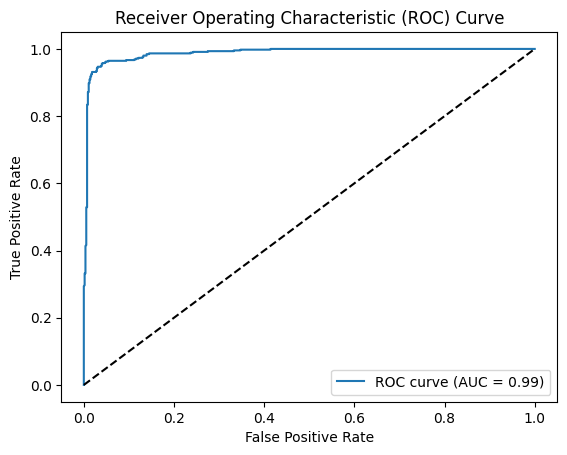

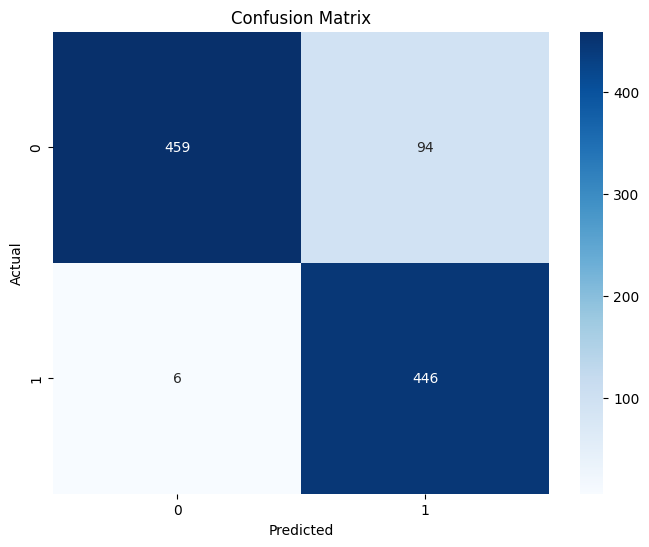

              precision    recall  f1-score   support

           0       0.99      0.83      0.90       553
           1       0.83      0.99      0.90       452

    accuracy                           0.90      1005
   macro avg       0.91      0.91      0.90      1005
weighted avg       0.91      0.90      0.90      1005



In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, auc, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification, AdamW
import matplotlib.pyplot as plt
import seaborn as sns

# Rest of the code

# Evaluation
model.eval()
y_pred = []
y_true = []
probabilities = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        predictions = torch.argmax(logits, dim=1)
        prob = torch.softmax(logits, dim=1)

        y_pred.extend(predictions.cpu().numpy())
        y_true.extend(labels.cpu().numpy())
        probabilities.extend(prob.cpu().numpy())

# Convert probabilities to NumPy array
probabilities = np.array(probabilities)

# Calculate evaluation metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_true, probabilities[:, 1])
plt.figure()
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, probabilities[:, 1])
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Confusion Matrix with Heatmap
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
report = classification_report(y_true, y_pred)
print(report)

**Indic Distilbert**

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import numpy as np
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Step 1: Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("ai4bharat/indic-bert")
model = AutoModelForSequenceClassification.from_pretrained("ai4bharat/indic-bert", num_labels=2)

# Step 2: Load and preprocess the dataset
df = pd.read_csv('/content/drive/MyDrive/merge_check.csv')

# Split the dataset into train and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Step 3: Preprocess the data and create input tensors for training set
train_headlines = train_df['Headline'].values
train_content = train_df['Content'].values
train_labels = train_df['Label'].values

train_texts = train_headlines + ' ' + train_content

train_input_ids = []
train_attention_masks = []

for text in train_texts:
    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=512,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    train_input_ids.append(encoding['input_ids'])
    train_attention_masks.append(encoding['attention_mask'])

train_input_ids = torch.cat(train_input_ids, dim=0)
train_attention_masks = torch.cat(train_attention_masks, dim=0)
train_labels = torch.tensor(train_labels)

# Create a TensorDataset and DataLoader for training set
train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)

# Step 4: Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

for epoch in range(10):
    model.train()
    total_loss = 0

    for batch in train_dataloader:
        input_ids_batch = batch[0].to(device)
        attention_masks_batch = batch[1].to(device)
        labels_batch = batch[2].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids_batch, attention_mask=attention_masks_batch, labels=labels_batch)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    average_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch+1} Loss: {average_loss:.4f}")

# Step 5: Preprocess the data and create input tensors for test set
test_headlines = test_df['Headline'].values
test_content = test_df['Content'].values
test_labels = test_df['Label'].values

test_texts = test_headlines + ' ' + test_content

test_input_ids = []
test_attention_masks = []

for text in test_texts:
    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=512,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    test_input_ids.append(encoding['input_ids'])
    test_attention_masks.append(encoding['attention_mask'])

test_input_ids = torch.cat(test_input_ids, dim=0)
test_attention_masks = torch.cat(test_attention_masks, dim=0)
test_labels = torch.tensor(test_labels)

# Create a TensorDataset and DataLoader for test set
test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Step 6: Evaluation
model.eval()
eval_loss = 0
predictions = []
all_labels = []

with torch.no_grad():
    for batch in test_dataloader:
        input_ids_batch, attention_mask_batch, labels_batch = tuple(t.to(device) for t in batch)
        outputs = model(input_ids_batch, attention_mask=attention_mask_batch, labels=labels_batch)
        loss = outputs.loss
        logits = outputs.logits

        eval_loss += loss.item()
        predictions.extend(torch.argmax(logits, dim=1).cpu().numpy())
        all_labels.extend(labels_batch.cpu().numpy())

eval_loss = eval_loss / len(test_dataloader)
accuracy = accuracy_score(all_labels, predictions)
precision = precision_score(all_labels, predictions)
recall = recall_score(all_labels, predictions)
f1 = f1_score(all_labels, predictions)

print(f"Evaluation Loss: {eval_loss:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Some weights of the model checkpoint at ai4bharat/indic-bert were not used when initializing AlbertForSequenceClassification: ['predictions.dense.bias', 'predictions.bias', 'predictions.decoder.weight', 'predictions.LayerNorm.bias', 'predictions.dense.weight', 'sop_classifier.classifier.weight', 'sop_classifier.classifier.bias', 'predictions.LayerNorm.weight', 'predictions.decoder.bias']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indi

Epoch 1 Loss: 0.5511
Epoch 2 Loss: 0.4789
Epoch 3 Loss: 0.3131
Epoch 4 Loss: 0.2441
Epoch 5 Loss: 0.2137
Epoch 6 Loss: 0.1825
Epoch 7 Loss: 0.1681
Epoch 8 Loss: 0.1454
Epoch 9 Loss: 0.1207
Epoch 10 Loss: 0.0918
Evaluation Loss: 0.1567
Accuracy: 0.9463
Precision: 0.9774
Recall: 0.8962
F1-Score: 0.9350


Evaluation Loss: 0.1567
Accuracy: 0.9463
Precision: 0.9774
Recall: 0.8962
F1-Score: 0.9350


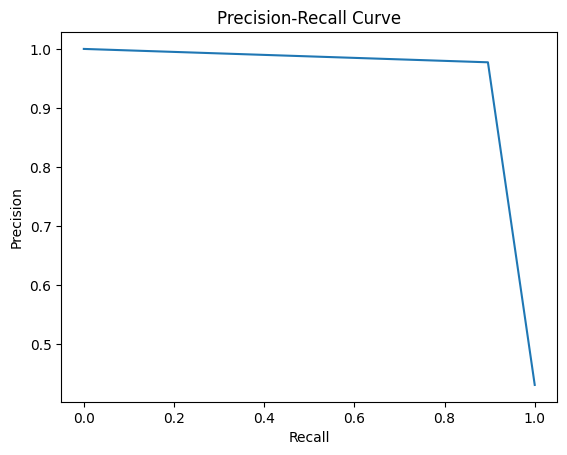

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# Step 6: Evaluation
model.eval()
eval_loss = 0
predictions = []
all_labels = []

with torch.no_grad():
    for batch in test_dataloader:
        input_ids_batch, attention_mask_batch, labels_batch = tuple(t.to(device) for t in batch)
        outputs = model(input_ids_batch, attention_mask=attention_mask_batch, labels=labels_batch)
        loss = outputs.loss
        logits = outputs.logits

        eval_loss += loss.item()
        predictions.extend(torch.argmax(logits, dim=1).cpu().numpy())
        all_labels.extend(labels_batch.cpu().numpy())

eval_loss = eval_loss / len(test_dataloader)
accuracy = accuracy_score(all_labels, predictions)
precision = precision_score(all_labels, predictions)
recall = recall_score(all_labels, predictions)
f1 = f1_score(all_labels, predictions)

print(f"Evaluation Loss: {eval_loss:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Step 7: Generate precision-recall curve
probs = torch.nn.functional.softmax(torch.tensor(predictions).float(), dim=0).numpy()
precision, recall, _ = precision_recall_curve(all_labels, probs)

# Step 8: Plot precision-recall curve
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

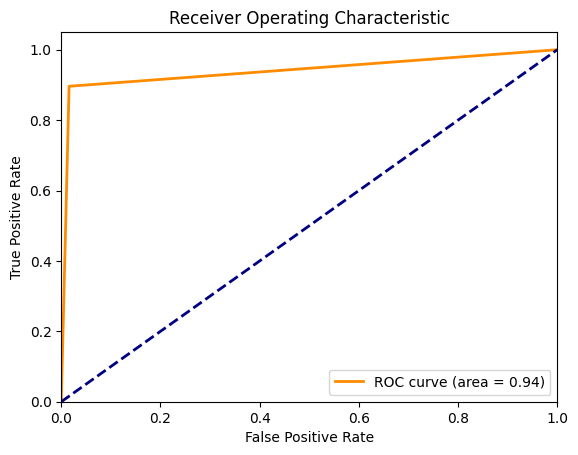

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Step 7: Generate ROC curve
fpr, tpr, thresholds = roc_curve(all_labels, probs)
roc_auc = auc(fpr, tpr)

# Step 8: Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

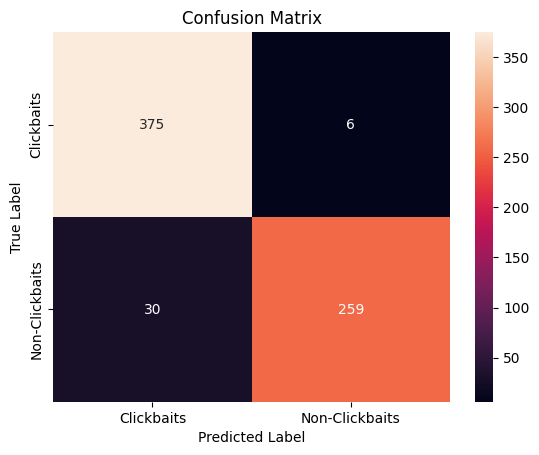

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.98      0.95       381
           1       0.98      0.90      0.94       289

    accuracy                           0.95       670
   macro avg       0.95      0.94      0.94       670
weighted avg       0.95      0.95      0.95       670



In [ ]:
import torch
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import numpy as np
from sklearn.metrics import confusion_matrix,classification_report
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Rest of the code...

# Step 7: Evaluation
model.eval()
eval_loss = 0
predictions = []
all_labels = []

with torch.no_grad():
    for batch in test_dataloader:
        input_ids_batch, attention_mask_batch, labels_batch = tuple(t.to(device) for t in batch)
        outputs = model(input_ids_batch, attention_mask=attention_mask_batch, labels=labels_batch)
        loss = outputs.loss
        logits = outputs.logits

        eval_loss += loss.item()
        predictions.extend(torch.argmax(logits, dim=1).cpu().numpy())
        all_labels.extend(labels_batch.cpu().numpy())

eval_loss = eval_loss / len(test_dataloader)

# Compute confusion matrix
confusion_mat = confusion_matrix(all_labels, predictions)

# Plot confusion matrix
labels = ['Clickbaits', 'Non-Clickbaits']
sns.heatmap(confusion_mat, annot=True, fmt="d", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Generate classification report
report = classification_report(all_labels, predictions)
print("Classification Report:")
print(report)




**Bangla Bert**

In [ ]:
import torch
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
from torch.utils.data import TensorDataset

# Step 1: Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("sagorsarker/bangla-bert-base")
model = AutoModelForSequenceClassification.from_pretrained("sagorsarker/bangla-bert-base", num_labels=2)

import torch
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import pandas as pd
from torch.utils.data import TensorDataset

# Step 1: Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("sagorsarker/bangla-bert-base")
model = AutoModelForSequenceClassification.from_pretrained("sagorsarker/bangla-bert-base", num_labels=2)

# Step 2: Load and preprocess the dataset
df = pd.read_csv('/content/drive/MyDrive/merge_check.csv')

# Step 2: Prepare the dataset
headlines = df['Headline'].values
content = df['Content'].values
labels = df['Label'].values

texts = headlines + ' ' + content

input_ids = []
attention_masks = []

for text in texts:
    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=512,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    input_ids.append(encoding['input_ids'])
    attention_masks.append(encoding['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Step 3: Split the dataset into train and test sets
train_inputs, test_inputs, train_masks, test_masks, train_labels, test_labels = train_test_split(
    input_ids, attention_masks, labels, test_size=0.2, random_state=42
)

# Step 4: Create TensorDatasets and DataLoaders for train and test sets
train_dataset = TensorDataset(train_inputs, train_masks, train_labels)
test_dataset = TensorDataset(test_inputs, test_masks, test_labels)

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)


# Step 4: Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

for epoch in range(10):
    model.train()
    total_loss = 0

    for batch in train_dataloader:
        input_ids_batch = batch[0].to(device)
        attention_masks_batch = batch[1].to(device)
        labels_batch = batch[2].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids_batch, attention_mask=attention_masks_batch, labels=labels_batch)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    average_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch+1} Loss: {average_loss:.4f}")

# Step 7: Evaluation
model.eval()
eval_loss = 0
predictions = []
all_labels = []

with torch.no_grad():
    for batch in test_dataloader:
        input_ids_batch, attention_mask_batch, labels_batch = tuple(t.to(device) for t in batch)
        outputs = model(input_ids_batch, attention_mask=attention_mask_batch, labels=labels_batch)
        loss = outputs.loss
        logits = outputs.logits

        eval_loss += loss.item()
        predictions.extend(torch.argmax(logits, dim=1).cpu().numpy())
        all_labels.extend(labels_batch.cpu().numpy())

eval_loss = eval_loss / len(test_dataloader)
accuracy = accuracy_score(all_labels, predictions)
precision = precision_score(all_labels, predictions)
recall = recall_score(all_labels, predictions)
f1 = f1_score(all_labels, predictions)

print(f"Evaluation Loss: {eval_loss:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Step 8: Inference
new_texts = ["New example sentence 1", "New example sentence 2"]
new_encoding = tokenizer(new_texts, truncation=True, padding=True)
new_input_ids = torch.tensor(new_encoding['input_ids']).to(device)
new_attention_mask = torch.tensor(new_encoding['attention_mask']).to(device)

model.eval()
with torch.no_grad():
    outputs = model(new_input_ids, attention_mask=new_attention_mask)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=1).cpu().numpy()

print("Predictions:")
for text, prediction in zip(new_texts, predictions):
    print(f"Text: {text} - Prediction: {prediction}")


Some weights of the model checkpoint at sagorsarker/bangla-bert-base were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sagorsarker/bangla-ber

Epoch 1 Loss: 0.2339
Epoch 2 Loss: 0.1170
Epoch 3 Loss: 0.0489
Epoch 4 Loss: 0.0167
Epoch 5 Loss: 0.0206
Epoch 6 Loss: 0.0091
Epoch 7 Loss: 0.0003
Epoch 8 Loss: 0.0001
Epoch 9 Loss: 0.0001
Epoch 10 Loss: 0.0001


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Evaluation Loss: 0.3496
Accuracy: 0.9522
Precision: 0.9446
Recall: 0.9446
F1-Score: 0.9446
Predictions:
Text: New example sentence 1 - Prediction: 0
Text: New example sentence 2 - Prediction: 0


Evaluation Loss: 0.3496
Accuracy: 0.9522
Precision: 0.9446
Recall: 0.9446
F1-Score: 0.9446


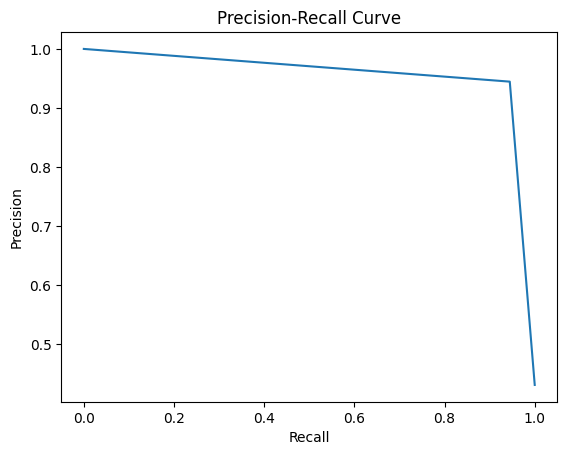

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# Step 6: Evaluation
model.eval()
eval_loss = 0
predictions = []
all_labels = []

with torch.no_grad():
    for batch in test_dataloader:
        input_ids_batch, attention_mask_batch, labels_batch = tuple(t.to(device) for t in batch)
        outputs = model(input_ids_batch, attention_mask=attention_mask_batch, labels=labels_batch)
        loss = outputs.loss
        logits = outputs.logits

        eval_loss += loss.item()
        predictions.extend(torch.argmax(logits, dim=1).cpu().numpy())
        all_labels.extend(labels_batch.cpu().numpy())

eval_loss = eval_loss / len(test_dataloader)
accuracy = accuracy_score(all_labels, predictions)
precision = precision_score(all_labels, predictions)
recall = recall_score(all_labels, predictions)
f1 = f1_score(all_labels, predictions)

print(f"Evaluation Loss: {eval_loss:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Step 7: Generate precision-recall curve
probs = torch.nn.functional.softmax(torch.tensor(predictions).float(), dim=0).numpy()
precision, recall, _ = precision_recall_curve(all_labels, probs)

# Step 8: Plot precision-recall curve
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

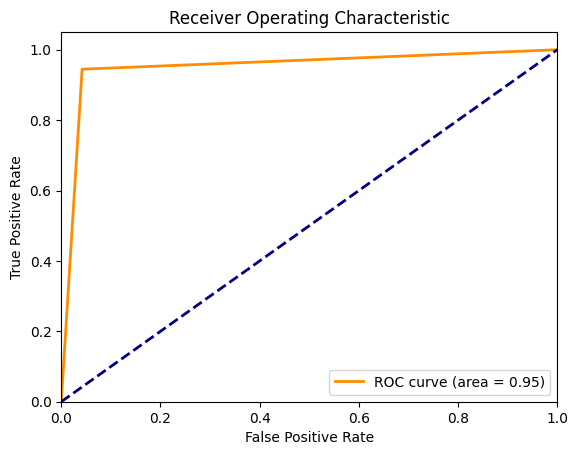

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Step 7: Generate ROC curve
fpr, tpr, thresholds = roc_curve(all_labels, probs)
roc_auc = auc(fpr, tpr)

# Step 8: Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

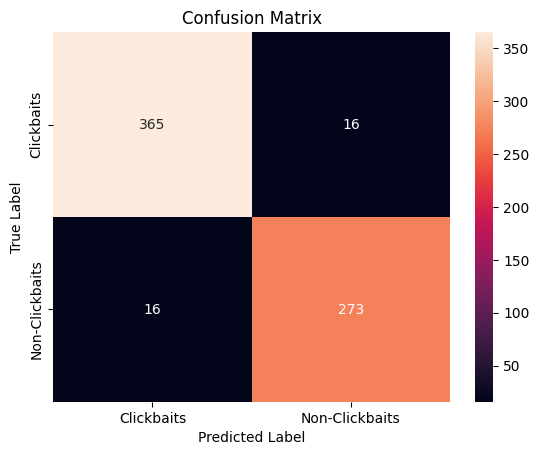

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       381
           1       0.94      0.94      0.94       289

    accuracy                           0.95       670
   macro avg       0.95      0.95      0.95       670
weighted avg       0.95      0.95      0.95       670



In [ ]:
import torch
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import numpy as np
from sklearn.metrics import confusion_matrix,classification_report
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Rest of the code...

# Step 7: Evaluation
model.eval()
eval_loss = 0
predictions = []
all_labels = []

with torch.no_grad():
    for batch in test_dataloader:
        input_ids_batch, attention_mask_batch, labels_batch = tuple(t.to(device) for t in batch)
        outputs = model(input_ids_batch, attention_mask=attention_mask_batch, labels=labels_batch)
        loss = outputs.loss
        logits = outputs.logits

        eval_loss += loss.item()
        predictions.extend(torch.argmax(logits, dim=1).cpu().numpy())
        all_labels.extend(labels_batch.cpu().numpy())

eval_loss = eval_loss / len(test_dataloader)

# Compute confusion matrix
confusion_mat = confusion_matrix(all_labels, predictions)

# Plot confusion matrix
labels = ['Clickbaits', 'Non-Clickbaits']
sns.heatmap(confusion_mat, annot=True, fmt="d", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Generate classification report
report = classification_report(all_labels, predictions)
print("Classification Report:")
print(report)


**Ensemble(xlm-roberta,indic distilbert,bangla bert)**

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, auc
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Load and preprocess your dataset
dataset_path = "/content/drive/MyDrive/merge_check.csv"  # Replace with your dataset path

df = pd.read_csv(dataset_path)

headlines = df['Headline'].values
content = df['Content'].values
labels = df['Label'].values

texts = headlines + ' ' + content

# Step 2: Split the dataset into train and test sets
train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

# Step 3: Load the tokenizers and models
tokenizer_xlmr = AutoTokenizer.from_pretrained("xlm-roberta-base")
model_xlmr = AutoModelForSequenceClassification.from_pretrained("xlm-roberta-base", num_labels=2)

tokenizer_indic = AutoTokenizer.from_pretrained("ai4bharat/indic-bert")
model_indic = AutoModelForSequenceClassification.from_pretrained("ai4bharat/indic-bert", num_labels=2)

tokenizer_bangla = AutoTokenizer.from_pretrained("sagorsarker/bangla-bert-base")
model_bangla = AutoModelForSequenceClassification.from_pretrained("sagorsarker/bangla-bert-base", num_labels=2)

# Step 4: Tokenize the train and test texts
train_texts = [text for text in train_texts]  # Convert to list
test_texts = [text for text in test_texts]  # Convert to list
train_encodings_xlmr = tokenizer_xlmr(train_texts, truncation=True, padding=True, max_length=512)
train_encodings_indic = tokenizer_indic(train_texts, truncation=True, padding=True, max_length=512)
train_encodings_bangla = tokenizer_bangla(train_texts, truncation=True, padding=True, max_length=512)

test_encodings_xlmr = tokenizer_xlmr(test_texts, truncation=True, padding=True, max_length=512)
test_encodings_indic = tokenizer_indic(test_texts, truncation=True, padding=True, max_length=512)
test_encodings_bangla = tokenizer_bangla(test_texts, truncation=True, padding=True, max_length=512)

# Step 5: Create TensorDatasets and DataLoaders for train and test sets for each model
train_dataset_xlmr = TensorDataset(
    torch.tensor(train_encodings_xlmr['input_ids']),
    torch.tensor(train_encodings_xlmr['attention_mask']),
    torch.tensor(train_labels)
)
test_dataset_xlmr = TensorDataset(
    torch.tensor(test_encodings_xlmr['input_ids']),
    torch.tensor(test_encodings_xlmr['attention_mask']),
    torch.tensor(test_labels)
)

train_dataset_indic = TensorDataset(
    torch.tensor(train_encodings_indic['input_ids']),
    torch.tensor(train_encodings_indic['attention_mask']),
    torch.tensor(train_labels)
)
test_dataset_indic = TensorDataset(
    torch.tensor(test_encodings_indic['input_ids']),
    torch.tensor(test_encodings_indic['attention_mask']),
    torch.tensor(test_labels)
)

train_dataset_bangla = TensorDataset(
    torch.tensor(train_encodings_bangla['input_ids']),
    torch.tensor(train_encodings_bangla['attention_mask']),
    torch.tensor(train_labels)
)
test_dataset_bangla = TensorDataset(
    torch.tensor(test_encodings_bangla['input_ids']),
    torch.tensor(test_encodings_bangla['attention_mask']),
    torch.tensor(test_labels)
)

train_dataloader_xlmr = DataLoader(train_dataset_xlmr, batch_size=8, shuffle=True)
test_dataloader_xlmr = DataLoader(test_dataset_xlmr, batch_size=8, shuffle=False)

train_dataloader_indic = DataLoader(train_dataset_indic, batch_size=8, shuffle=True)
test_dataloader_indic = DataLoader(test_dataset_indic, batch_size=8, shuffle=False)

train_dataloader_bangla = DataLoader(train_dataset_bangla, batch_size=8, shuffle=True)
test_dataloader_bangla = DataLoader(test_dataset_bangla, batch_size=8, shuffle=False)

# Step 6: Define the weights for weighted averaging
weights = [0.3, 0.3, 0.4]  # Adjust the weights according to preference

# Step 7: Training loop for each model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_xlmr.to(device)
model_indic.to(device)
model_bangla.to(device)

optimizer_xlmr = torch.optim.AdamW(model_xlmr.parameters(), lr=2e-5)
optimizer_indic = torch.optim.AdamW(model_indic.parameters(), lr=2e-5)
optimizer_bangla = torch.optim.AdamW(model_bangla.parameters(), lr=2e-5)

num_epochs = 10

for epoch in range(num_epochs):
    model_xlmr.train()
    model_indic.train()
    model_bangla.train()

    total_loss_xlmr = 0
    total_loss_indic = 0
    total_loss_bangla = 0

    for batch_xlmr, batch_indic, batch_bangla in zip(train_dataloader_xlmr, train_dataloader_indic, train_dataloader_bangla):
        input_ids_xlmr_batch, attention_masks_xlmr_batch, labels_batch_xlmr = batch_xlmr
        input_ids_indic_batch, attention_masks_indic_batch, labels_batch_indic = batch_indic
        input_ids_bangla_batch, attention_masks_bangla_batch, labels_batch_bangla = batch_bangla

        input_ids_xlmr_batch = input_ids_xlmr_batch.to(device)
        attention_masks_xlmr_batch = attention_masks_xlmr_batch.to(device)
        labels_batch_xlmr = labels_batch_xlmr.to(device)

        input_ids_indic_batch = input_ids_indic_batch.to(device)
        attention_masks_indic_batch = attention_masks_indic_batch.to(device)
        labels_batch_indic = labels_batch_indic.to(device)

        input_ids_bangla_batch = input_ids_bangla_batch.to(device)
        attention_masks_bangla_batch = attention_masks_bangla_batch.to(device)
        labels_batch_bangla = labels_batch_bangla.to(device)

        optimizer_xlmr.zero_grad()
        optimizer_indic.zero_grad()
        optimizer_bangla.zero_grad()

        outputs_xlmr = model_xlmr(input_ids_xlmr_batch, attention_mask=attention_masks_xlmr_batch, labels=labels_batch_xlmr)
        outputs_indic = model_indic(input_ids_indic_batch, attention_mask=attention_masks_indic_batch, labels=labels_batch_indic)
        outputs_bangla = model_bangla(input_ids_bangla_batch, attention_mask=attention_masks_bangla_batch, labels=labels_batch_bangla)

        loss_xlmr = outputs_xlmr.loss
        loss_indic = outputs_indic.loss
        loss_bangla = outputs_bangla.loss

        total_loss_xlmr += loss_xlmr.item()
        total_loss_indic += loss_indic.item()
        total_loss_bangla += loss_bangla.item()

        loss_xlmr.backward()
        loss_indic.backward()
        loss_bangla.backward()

        optimizer_xlmr.step()
        optimizer_indic.step()
        optimizer_bangla.step()

    average_loss_xlmr = total_loss_xlmr / len(train_dataloader_xlmr)
    average_loss_indic = total_loss_indic / len(train_dataloader_indic)
    average_loss_bangla = total_loss_bangla / len(train_dataloader_bangla)

    print(f"Epoch {epoch+1}")
    print(f"XLM-RoBERTa Loss: {average_loss_xlmr:.4f}")
    print(f"Indic DistilBERT Loss: {average_loss_indic:.4f}")
    print(f"Bangla BERT Loss: {average_loss_bangla:.4f}")

# Step 8: Evaluation and ensemble predictions
model_xlmr.eval()
model_indic.eval()
model_bangla.eval()

predictions = []
all_labels = []

with torch.no_grad():
    for batch_xlmr, batch_indic, batch_bangla in zip(test_dataloader_xlmr, test_dataloader_indic, test_dataloader_bangla):
        input_ids_xlmr_batch, attention_masks_xlmr_batch, labels_batch_xlmr = batch_xlmr
        input_ids_indic_batch, attention_masks_indic_batch, labels_batch_indic = batch_indic
        input_ids_bangla_batch, attention_masks_bangla_batch, labels_batch_bangla = batch_bangla

        input_ids_xlmr_batch = input_ids_xlmr_batch.to(device)
        attention_masks_xlmr_batch = attention_masks_xlmr_batch.to(device)

        input_ids_indic_batch = input_ids_indic_batch.to(device)
        attention_masks_indic_batch = attention_masks_indic_batch.to(device)

        input_ids_bangla_batch = input_ids_bangla_batch.to(device)
        attention_masks_bangla_batch = attention_masks_bangla_batch.to(device)

        outputs_xlmr = model_xlmr(input_ids_xlmr_batch, attention_mask=attention_masks_xlmr_batch)
        outputs_indic = model_indic(input_ids_indic_batch, attention_mask=attention_masks_indic_batch)
        outputs_bangla = model_bangla(input_ids_bangla_batch, attention_mask=attention_masks_bangla_batch)

        logits_xlmr = outputs_xlmr.logits
        logits_indic = outputs_indic.logits
        logits_bangla = outputs_bangla.logits

        # Weighted averaging
        logits_ensemble = (weights[0] * logits_xlmr + weights[1] * logits_indic + weights[2] * logits_bangla) / sum(weights)

        predictions.extend(torch.argmax(logits_ensemble, dim=1).cpu().numpy())
        all_labels.extend(labels_batch_xlmr.cpu().numpy())

accuracy = accuracy_score(all_labels, predictions)
precision = precision_score(all_labels, predictions)
recall = recall_score(all_labels, predictions)
f1 = f1_score(all_labels, predictions)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")








Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.den

Epoch 1
XLM-RoBERTa Loss: 0.2689
Indic DistilBERT Loss: 0.5534
Bangla BERT Loss: 0.2420
Epoch 2
XLM-RoBERTa Loss: 0.1786
Indic DistilBERT Loss: 0.4675
Bangla BERT Loss: 0.1050
Epoch 3
XLM-RoBERTa Loss: 0.4049
Indic DistilBERT Loss: 0.3351
Bangla BERT Loss: 0.0442
Epoch 4
XLM-RoBERTa Loss: 0.6989
Indic DistilBERT Loss: 0.3330
Bangla BERT Loss: 0.0181
Epoch 5
XLM-RoBERTa Loss: 0.6973
Indic DistilBERT Loss: 0.2451
Bangla BERT Loss: 0.0256
Epoch 6
XLM-RoBERTa Loss: 0.3114
Indic DistilBERT Loss: 0.2141
Bangla BERT Loss: 0.0139
Epoch 7
XLM-RoBERTa Loss: 0.1843
Indic DistilBERT Loss: 0.1929
Bangla BERT Loss: 0.0065
Epoch 8
XLM-RoBERTa Loss: 0.1886
Indic DistilBERT Loss: 0.1985
Bangla BERT Loss: 0.0109
Epoch 9
XLM-RoBERTa Loss: 0.1474
Indic DistilBERT Loss: 0.1565
Bangla BERT Loss: 0.0035
Epoch 10
XLM-RoBERTa Loss: 0.1256
Indic DistilBERT Loss: 0.1528
Bangla BERT Loss: 0.0003
Accuracy: 0.9567
Precision: 0.9483
Recall: 0.9516
F1-Score: 0.9499


Accuracy: 0.9567
Precision: 0.9483
Recall: 0.9516
F1-Score: 0.9499


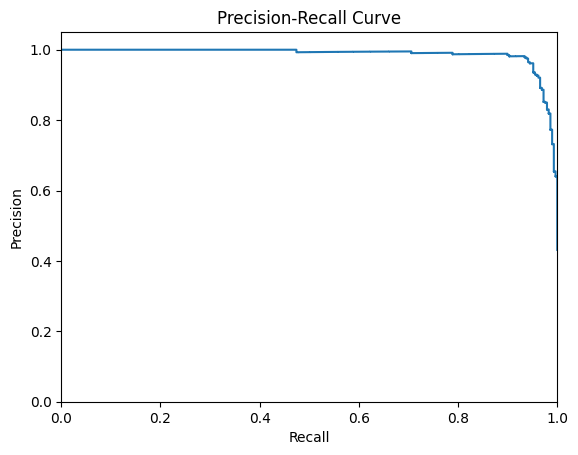

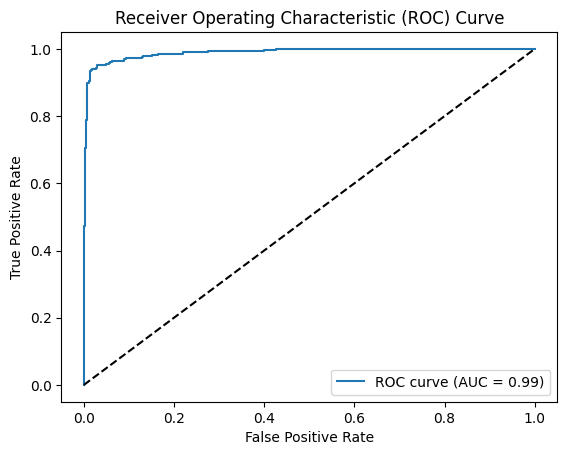

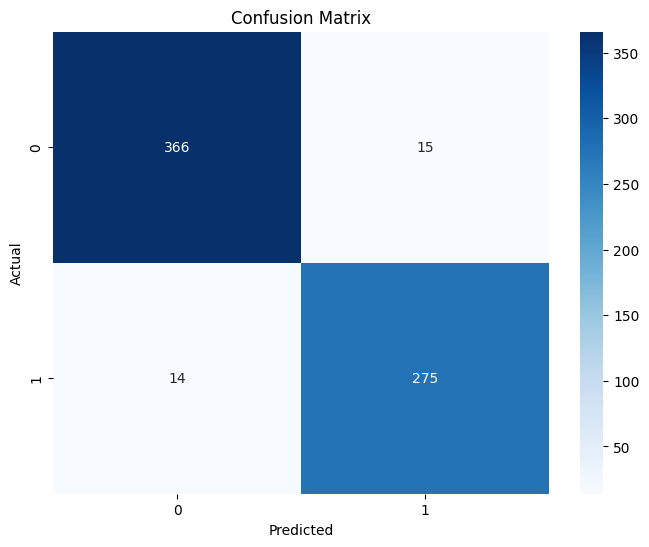

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       381
           1       0.95      0.95      0.95       289

    accuracy                           0.96       670
   macro avg       0.96      0.96      0.96       670
weighted avg       0.96      0.96      0.96       670



In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, auc, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Rest of the code

# Step 8: Evaluation and ensemble predictions
model_xlmr.eval()
model_indic.eval()
model_bangla.eval()

predictions = []
all_labels = []
probabilities = []

with torch.no_grad():
    for batch_xlmr, batch_indic, batch_bangla in zip(test_dataloader_xlmr, test_dataloader_indic, test_dataloader_bangla):
        input_ids_xlmr_batch, attention_masks_xlmr_batch, labels_batch_xlmr = batch_xlmr
        input_ids_indic_batch, attention_masks_indic_batch, labels_batch_indic = batch_indic
        input_ids_bangla_batch, attention_masks_bangla_batch, labels_batch_bangla = batch_bangla

        input_ids_xlmr_batch = input_ids_xlmr_batch.to(device)
        attention_masks_xlmr_batch = attention_masks_xlmr_batch.to(device)

        input_ids_indic_batch = input_ids_indic_batch.to(device)
        attention_masks_indic_batch = attention_masks_indic_batch.to(device)

        input_ids_bangla_batch = input_ids_bangla_batch.to(device)
        attention_masks_bangla_batch = attention_masks_bangla_batch.to(device)

        outputs_xlmr = model_xlmr(input_ids_xlmr_batch, attention_mask=attention_masks_xlmr_batch)
        outputs_indic = model_indic(input_ids_indic_batch, attention_mask=attention_masks_indic_batch)
        outputs_bangla = model_bangla(input_ids_bangla_batch, attention_mask=attention_masks_bangla_batch)

        logits_xlmr = outputs_xlmr.logits
        logits_indic = outputs_indic.logits
        logits_bangla = outputs_bangla.logits

        # Weighted averaging
        logits_ensemble = (weights[0] * logits_xlmr + weights[1] * logits_indic + weights[2] * logits_bangla) / sum(weights)

        predictions.extend(torch.argmax(logits_ensemble, dim=1).cpu().numpy())
        all_labels.extend(labels_batch_xlmr.cpu().numpy())
        probabilities.extend(torch.softmax(logits_ensemble, dim=1).cpu().numpy())

# Convert probabilities to NumPy array
probabilities = np.array(probabilities)

# Calculate metrics
accuracy = accuracy_score(all_labels, predictions)
precision = precision_score(all_labels, predictions)
recall = recall_score(all_labels, predictions)
f1 = f1_score(all_labels, predictions)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(all_labels, probabilities[:, 1])
plt.figure()
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(all_labels, probabilities[:, 1])
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Confusion Matrix with Heatmap
cm = confusion_matrix(all_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
report = classification_report(all_labels, predictions)
print(report)


